In [ ]:
import mysql.connector
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

#import spacy
#from spacytextblob.spacytextblob import SpacyTextBlob
from transformers import pipeline


/Users/skotha/opt/anaconda3/envs/dfunc/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Access DB

In [ ]:
db = mysql.connector.connect(
    host = '', #removed
    user = '', #removed
    password = '', #removed
    database = '') #removed

In [ ]:
cur = db.cursor()

In [ ]:
try:
    query = "select * from feedback_entries limit 5000;"
    new_data = pd.read_sql(query, db)
    cur.close()
except Exception as e:
    cur.close()
    print(str(e))

/Users/skotha/opt/anaconda3/envs/dfunc/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [ ]:
new_data

,team_id,id,title,entry,data_source,sentiment
0,881,2739024,,When I picked car it was 25 $ when my receipt ...,gplay,NEGATIVE
1,988,2387246,Target IT systems are less than ideal,"As a disclaimer, I don't think it's the fault ...",Forum,NEGATIVE
2,881,2739001,,Good,gplay,POSITIVE
3,849,1872388,Jump back to the previous tab? (not with Alt +...,I closed the option that lets to toggle over t...,Reddit,NEGATIVE
4,881,2708601,,"My driver today was excellent!!! Great Person,...",gplay,POSITIVE
...,...,...,...,...,...,...
295,881,2739014,,I wait for the lyft driver and go outside on t...,gplay,NEGATIVE
296,849,1872139,Does Google Pay work on Edge mobile on Android?,Looking to change from Chrome to Edge. There a...,Reddit,NEUTRAL
297,988,2601340,Can someone at DC explain repacks to me?,"We get repacks that are filled to bursting, so...",Reddit,NEGATIVE
298,849,2155568,The file is being flagged as a threat Should I...,I have Norton Security and many times it flags...,Reddit,NEGATIVE


### Base Model Performance

In [ ]:
base_df = pd.read_csv('sentiment_annotations.csv')

In [ ]:
base_df

,team_id,entry_id,title,entry,data_source,sentiment_output,annotated_sentiment,correct?
0,881,2739024,NaN,When I picked car it was 25 $ when my receipt ...,gplay,NEGATIVE,NEGATIVE,1
1,988,2387246,Target IT systems are less than ideal,"As a disclaimer, I don't think it's the fault ...",Forum,NEGATIVE,NEGATIVE,1
2,881,2739001,NaN,Good,gplay,POSITIVE,POSITIVE,1
3,849,1872388,Jump back to the previous tab? (not with Alt +...,I closed the option that lets to toggle over t...,Reddit,NEGATIVE,NEGATIVE,1
4,881,2708601,NaN,"My driver today was excellent!!! Great Person,...",gplay,POSITIVE,POSITIVE,1
...,...,...,...,...,...,...,...,...
295,881,2739014,NaN,I wait for the lyft driver and go outside on t...,gplay,NEGATIVE,NEGATIVE,1
296,849,1872139,Does Google Pay work on Edge mobile on Android?,Looking to change from Chrome to Edge. There a...,Reddit,NEUTRAL,NEUTRAL,1
297,988,2601340,Can someone at DC explain repacks to me?,"We get repacks that are filled to bursting, so...",Reddit,NEGATIVE,NEGATIVE,1
298,849,2155568,The file is being flagged as a threat Should I...,I have Norton Security and many times it flags...,Reddit,NEGATIVE,NEUTRAL,0


In [ ]:
classes = list(set(base_df['annotated_sentiment']))

In [ ]:
classes

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
cm = confusion_matrix(base_df['annotated_sentiment'], base_df['sentiment_output'], labels=classes)

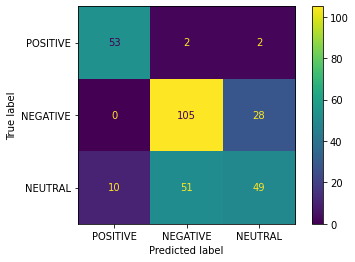

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

In [ ]:
#model struggles to distinguish neutral and negative; identifies neutral as negative
f1_score(base_df['annotated_sentiment'], base_df['sentiment_output'], average=None, labels = classes)

array([0.88333333, 0.72164948, 0.51851852])

A few observations regarding the base model:
- good at classifying positive comments
- not too good at classifying neutral comments
- often identifies neutral comments as negative
- class imbalance: double number of negative and neutral samples compared to positive ones

In [ ]:
Counter(base_df['annotated_sentiment'])

Counter({'NEGATIVE': 133, 'POSITIVE': 57, 'NEUTRAL': 110})

In [ ]:
Counter(new_data['sentiment'])

Counter({'NEGATIVE': 158, 'POSITIVE': 63, 'NEUTRAL': 79})

### Analyze Text Data

In [ ]:
base_df['title'].fillna('', inplace=True)
base_df['entry'].fillna('', inplace=True)

In [ ]:
#combining title and entry fields -> titles often indicators of sentiment
base_df['combo_text'] = base_df['title'] + '\n' + base_df['entry']

<Axes: >

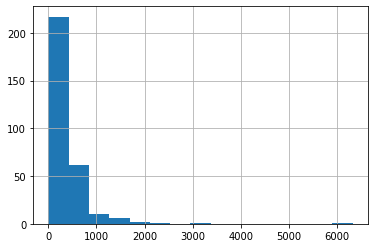

In [ ]:
#Most of the text pieces are under 1000 characters, but few are longer
base_df['combo_text'].apply(len).hist(bins=15)

### Apply Open-Source Model #1

In [ ]:
twitter_sentiment_model = pipeline(model='cardiffnlp/twitter-roberta-base-sentiment-latest')


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def apply_twitter_model(text):
    try:
        return twitter_sentiment_model(text)[0]
    except:
        return {'label': 'neutral', 'score': -1}

In [ ]:
twitter_sentiment_pred = [apply_twitter_model(doc) for doc in tqdm(base_df['combo_text'])]

100%|█████████████████████████████████████████| 300/300 [00:13<00:00, 22.03it/s]


In [ ]:
twitter_df = pd.DataFrame(twitter_sentiment_pred)

In [ ]:
twitter_df['label'] = twitter_df['label'].apply(lambda x: x.upper())

In [ ]:
twitter_df

,label,score
0,NEUTRAL,0.741999
1,NEGATIVE,0.787182
2,POSITIVE,0.725401
3,NEGATIVE,0.589469
4,POSITIVE,0.984516
...,...,...
295,NEGATIVE,0.755662
296,NEUTRAL,0.688206
297,NEGATIVE,0.749439
298,NEGATIVE,0.518077


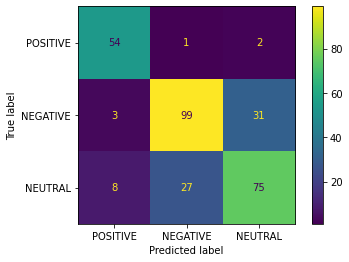

In [ ]:
cm = confusion_matrix(base_df['annotated_sentiment'], twitter_df['label'], labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

In [ ]:
f1_score(base_df['annotated_sentiment'], twitter_df['label'], average=None, labels = classes)


array([0.8852459 , 0.76153846, 0.68807339])

Few Comments on Twitter Model:
- better classifies neutral documents than base model
- marginal improvements for other classes

### Apply Open-Source Model #2

In [ ]:
product_reviews_model = pipeline(model='nlptown/bert-base-multilingual-uncased-sentiment')


In [ ]:
def apply_product_review_model(text):
    try:
        return product_reviews_model(text)[0]
    except:
        return {'label': '3', 'score': -1}

In [ ]:
product_review_pred = [apply_product_review_model(doc) for doc in tqdm(base_df['combo_text'])]

100%|█████████████████████████████████████████| 300/300 [00:14<00:00, 20.69it/s]


In [ ]:
product_review_df = pd.DataFrame(product_review_pred)

In [ ]:
product_review_df['stars'] = product_review_df['label']

In [ ]:
#consider modifying 2 stars to be either neutral or negative
product_review_df['label'].replace({'1 star': 'NEGATIVE', '2 stars': 'NEUTRAL', '3 stars': 'NEUTRAL', '4 stars': 'POSITIVE', '5 stars': 'POSITIVE'}, inplace=True)


In [ ]:
product_review_df

,label,score,stars
0,NEGATIVE,0.579627,1 star
1,NEUTRAL,0.422653,2 stars
2,POSITIVE,0.496963,4 stars
3,NEGATIVE,0.466265,1 star
4,POSITIVE,0.863094,5 stars
...,...,...,...
295,NEUTRAL,0.339607,2 stars
296,NEGATIVE,0.298822,1 star
297,NEGATIVE,0.479272,1 star
298,NEGATIVE,0.621195,1 star


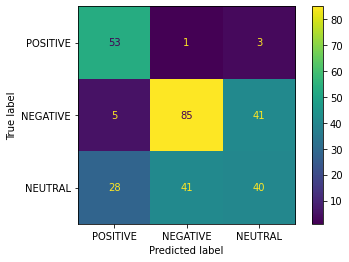

In [ ]:
cm = confusion_matrix(base_df['annotated_sentiment'], product_review_df['label'], labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

In [ ]:
f1_score(base_df['annotated_sentiment'], product_review_df['label'], average=None, labels = classes)


array([0.74125874, 0.65384615, 0.41237113])

Few Comments on Product Review Model:
- worse than base model wrt to all classes

### Combine Models' Predictions

In [ ]:
predictions_df = pd.concat([base_df['combo_text'], base_df['title'], base_df['annotated_sentiment'], base_df['sentiment_output'], twitter_df['score'], twitter_df['label']], axis=1)



In [ ]:
predictions_df.rename(columns={'label': 'twitter_roberta_label', 'score': 'twitter_roberta_score', 'sentiment_output': 'base_label'}, inplace=True)

In [ ]:
predictions_df = pd.concat([predictions_df, product_review_df], axis=1)

In [ ]:
predictions_df.rename(columns={'label': 'product_review_bert_label', 'score': 'product_review_bert_score', 'stars': 'product_review_bert_stars'}, inplace=True)


In [ ]:
predictions_df.head()

,combo_text,title,annotated_sentiment,base_label,twitter_roberta_score,twitter_roberta_label,product_review_bert_label,product_review_bert_score,product_review_bert_stars
0,\nWhen I picked car it was 25 $ when my receip...,,NEGATIVE,NEGATIVE,0.741999,NEUTRAL,NEGATIVE,0.579627,1 star
1,Target IT systems are less than ideal\nAs a di...,Target IT systems are less than ideal,NEGATIVE,NEGATIVE,0.787182,NEGATIVE,NEUTRAL,0.422653,2 stars
2,\nGood,,POSITIVE,POSITIVE,0.725401,POSITIVE,POSITIVE,0.496963,4 stars
3,Jump back to the previous tab? (not with Alt +...,Jump back to the previous tab? (not with Alt +...,NEGATIVE,NEGATIVE,0.589469,NEGATIVE,NEGATIVE,0.466265,1 star
4,\nMy driver today was excellent!!! Great Perso...,,POSITIVE,POSITIVE,0.984516,POSITIVE,POSITIVE,0.863094,5 stars


### Identify Top Model Weak Spots

The best of the three models (given the base model, twitter sentiment model, and product review model), is the twitter sentiment model. However, this model still struggles to distinguish neutral and negative examples - let's see if we can bolster this area. Specifically, focus on the case where negative examples are incorrectly classified as neutral.

In [ ]:
twitter_false_neutral = predictions_df.loc[((predictions_df['annotated_sentiment']=='NEGATIVE') & (predictions_df['twitter_roberta_label']=='NEUTRAL'))]



In [ ]:
len(twitter_false_neutral)

31

In [ ]:
twitter_false_negative = predictions_df.loc[((predictions_df['annotated_sentiment']=='NEUTRAL') & (predictions_df['twitter_roberta_label']=='NEGATIVE'))]



array([[<Axes: title={'center': 'twitter_roberta_score'}>,
        <Axes: title={'center': 'product_review_bert_score'}>]],
      dtype=object)

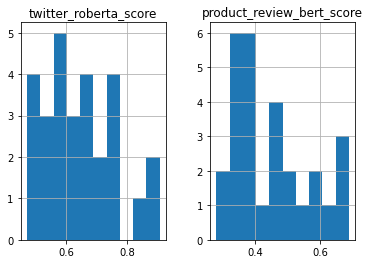

In [ ]:
twitter_false_neutral.loc[twitter_false_neutral["twitter_roberta_score"] > 0].hist()

<Axes: >

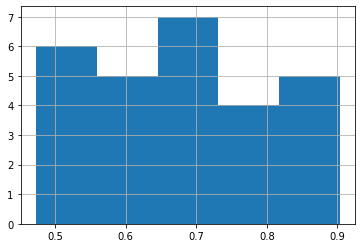

In [ ]:
twitter_false_negative["twitter_roberta_score"].hist(bins=5)

In [ ]:
list(twitter_false_neutral['combo_text'])[:5]

['\nWhen I picked car it was 25 $ when my receipt came it was 50.99',
 'Spouses and scheduling\nFrom the spouse and family of an employee…. Scheduling appointments more than 17 days out is hard sometimes. Please allow employees a minimum 10 days to request off, and provide an online way to post and accept requests for taking or swapping days/shifts. But also, it would be helpful if schedules were posted 9 days before a week starts, instead of the current 2 days. And please allow for requesting part of days off, so the other hours may be schedulable. Thanks.',
 'Stealing\nSo my coworker told me he kind of stole from target today. I was confused at first but he broke it down for me. I guess he bought a tv stand in store and tried returning online but wouldn’t allow him to, since it was purchased in stores. He has a small vehicle, so he said there was no way to get it to the store. The online people didn’t offer a pick up or anything. But I guess, he just took the item from the floor and 

In [ ]:
#0.5 quantile of twitter sentiment model scores for negative examples falsely identified as netural
twitter_false_neutral['twitter_roberta_score'].quantile(0.5)

0.6066074967384338

In [ ]:
#0.25 quantile of twitter sentiment model scores for negative examples falsely identified as netural
twitter_false_neutral['twitter_roberta_score'].quantile(0.25)

0.5235688388347626

In [ ]:
twitter_false_neutral[twitter_false_neutral['twitter_roberta_score'] < 0.52]

,combo_text,title,annotated_sentiment,base_label,twitter_roberta_score,twitter_roberta_label,product_review_bert_label,product_review_bert_score,product_review_bert_stars
12,Stealing\nSo my coworker told me he kind of st...,Stealing,NEGATIVE,NEGATIVE,0.510331,NEUTRAL,NEGATIVE,0.483245,1 star
37,Make sure your employee discounts are actually...,Make sure your employee discounts are actually...,NEGATIVE,NEGATIVE,0.493014,NEUTRAL,NEGATIVE,0.459614,1 star
51,Websites aren't loading properly?\nHi everyone...,Websites aren't loading properly?,NEGATIVE,NEGATIVE,-1.000000,NEUTRAL,3,-1.000000,3
168,"“we’re not hiring extra people, we know you gu...","“we’re not hiring extra people, we know you gu...",NEGATIVE,NEUTRAL,0.471186,NEUTRAL,NEUTRAL,0.289090,3 stars
175,"TL being too harsh on me, or am I actually not...","TL being too harsh on me, or am I actually not...",NEGATIVE,NEGATIVE,-1.000000,NEUTRAL,NEUTRAL,0.433680,2 stars
177,Specialty Contacting Another Store\nI was in T...,Specialty Contacting Another Store,NEGATIVE,NEGATIVE,0.492581,NEUTRAL,NEGATIVE,0.385434,1 star
198,(venting) TMs and TLs not respecting my pronou...,(venting) TMs and TLs not respecting my pronou...,NEGATIVE,NEGATIVE,-1.000000,NEUTRAL,3,-1.000000,3
221,Transitions and SPs in the same week\nWhose br...,Transitions and SPs in the same week,NEGATIVE,NEGATIVE,0.515502,NEUTRAL,NEGATIVE,0.352222,1 star


Based on the above table, I can make the following observations:
-When twitter sentiment model predicts 'NEUTRAL' but with a lower score (we define as below the first quartile of scores), all the ground-truth labels are 'NEGATIVE'

I am defining the following heuristic:
1. twitter_roberta_label predicts 'NEUTRAL' and
2. twitter_roberta_score less than first quartile of scores and

then the resulting prediction should be 'NEGATIVE'


We should test this heuristic below with a proper train-test split (wary of small class sizes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(predictions_df.loc[:, predictions_df.columns!='annotated_sentiment'], predictions_df['annotated_sentiment'], test_size=0.33, random_state=42)



In [ ]:
Counter(y_train)

Counter({'NEGATIVE': 94, 'POSITIVE': 37, 'NEUTRAL': 70})

In [ ]:
Counter(y_test)

Counter({'NEUTRAL': 40, 'POSITIVE': 20, 'NEGATIVE': 39})

In [ ]:
def create_ensemble_prediction(twitter_roberta_score, twitter_roberta_label, twitter_roberta_score_cutoff):
    if twitter_roberta_score < twitter_roberta_score_cutoff and twitter_roberta_label == 'NEUTRAL':
            return 'NEGATIVE'
    else:
        return twitter_roberta_label

In [ ]:
cutoff = twitter_false_neutral['twitter_roberta_score'].quantile(0.25)

In [ ]:
y_hat = X_test.apply(lambda x: create_ensemble_prediction(x['twitter_roberta_score'], x['twitter_roberta_label'], cutoff), axis=1)



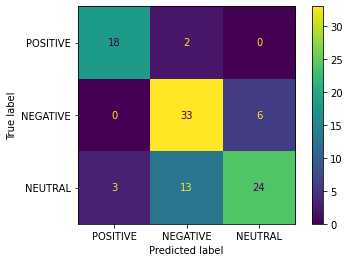

In [ ]:
cm = confusion_matrix(y_test, y_hat, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

In [ ]:
#testing heuristic on test split
f1_score(y_test, y_hat, average=None, labels = classes)


array([0.87804878, 0.75862069, 0.68571429])

In [ ]:
ensemble_pred = predictions_df.apply(lambda x: create_ensemble_prediction(x['twitter_roberta_score'], x['twitter_roberta_label'], cutoff), axis=1)


In [ ]:
predictions_df['ensemble_label'] = ensemble_pred

In [ ]:
#testing heuristic on all data
f1_score(predictions_df['annotated_sentiment'], predictions_df['ensemble_label'], average=None, labels = classes)


array([0.8852459 , 0.77818182, 0.68965517])

In [ ]:
Counter(predictions_df['ensemble_label'])

Counter({'NEUTRAL': 93, 'NEGATIVE': 142, 'POSITIVE': 65})

In [ ]:
Counter(predictions_df['twitter_roberta_label'])

Counter({'NEUTRAL': 108, 'NEGATIVE': 127, 'POSITIVE': 65})

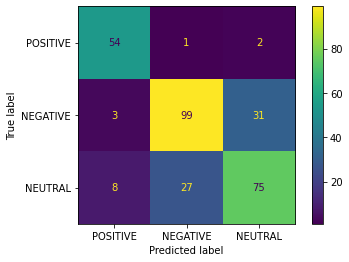

In [ ]:
#confusion matrix for twitter sentiment model on all data
cm = confusion_matrix(predictions_df['annotated_sentiment'], predictions_df['twitter_roberta_label'], labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

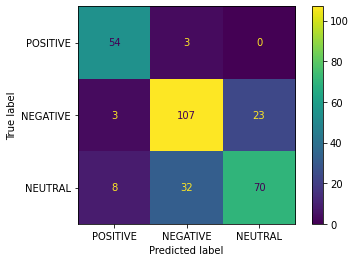

In [ ]:
#confusion matrix for newly modified twitter sentiment model on all data
cm = confusion_matrix(predictions_df['annotated_sentiment'], predictions_df['ensemble_label'], labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

There's minimal difference in the F1 scores between the modified twitter sentiment model we just defined and the twitter sentiment model we created first.

However, this modified model does reduce the number of ground-truth negative labels incorrectly labeled as neutral. It errs on the side of declaring instances negative while the original twitter sentiment model errs on the side of declaring instances neutral (when only considering the neutral-negative classes).

### Calculate Final Metrics

#### Accuracy

In [ ]:
#base model accuracy
accuracy_score(predictions_df['annotated_sentiment'], predictions_df['base_label'])

0.69

In [ ]:
#twitter sentiment (roberta) model accuracy
accuracy_score(predictions_df['annotated_sentiment'], predictions_df['twitter_roberta_label'])

0.76

In [ ]:
# modified twitter sentiment model accuracy
accuracy_score(predictions_df['annotated_sentiment'], predictions_df['ensemble_label'])

0.77

#### Individual Class F1 Scores and Weighted F1 Scores

In [ ]:
#reminder of class order for F1 scores
classes

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
# base model
f1_score(predictions_df['annotated_sentiment'], predictions_df['base_label'], average=None, labels = classes)


array([0.88333333, 0.72164948, 0.51851852])

In [ ]:
# twitter sentiment (roberta) model
f1_score(predictions_df['annotated_sentiment'], predictions_df['twitter_roberta_label'], average=None, labels = classes)


array([0.8852459 , 0.76153846, 0.68807339])

In [ ]:
# modified twitter sentiment model
f1_score(predictions_df['annotated_sentiment'], predictions_df['ensemble_label'], average=None, labels = classes)


array([0.8852459 , 0.77818182, 0.68965517])

In [ ]:
# base model
f1_score(predictions_df['annotated_sentiment'], predictions_df['base_label'], average="weighted", labels = classes)


0.67788806160112

In [ ]:
# twitter sentiment (roberta) model

f1_score(predictions_df['annotated_sentiment'], predictions_df['twitter_roberta_label'], average="weighted", labels = classes)


0.7581056839085114

In [ ]:
# modified twitter sentiment model
f1_score(predictions_df['annotated_sentiment'], predictions_df['ensemble_label'], average="weighted", labels = classes)


0.7660642239238056

### Predict New Data

In [ ]:
new_data['title'].fillna('', inplace=True)
new_data['entry'].fillna('', inplace=True)
new_data['combo_text'] = new_data['title'] + '\n' + new_data['entry']

In [ ]:
twitter_new_data = [apply_twitter_model(doc) for doc in tqdm(new_data['combo_text'])]

100%|█████████████████████████████████████████| 300/300 [00:14<00:00, 20.39it/s]


In [ ]:
#product_review_new_data = [apply_product_review_model(doc) for doc in tqdm(new_data['combo_text'])]

100%|█████████████████████████████████████████| 300/300 [00:14<00:00, 20.13it/s]


In [ ]:
twitter_new_data_df = pd.DataFrame(twitter_new_data).rename(columns={'label': 'twitter_label', 'score': 'twitter_score'})
twitter_new_data_df['twitter_label'] = twitter_new_data_df['twitter_label'].apply(lambda x: x.upper())


In [ ]:
#pr_new_data_df = pd.DataFrame(product_review_new_data).rename(columns={'label': 'pr_stars', 'score': 'pr_score'})

In [ ]:
#pred_new_data = pd.concat([twitter_new_data_df, pr_new_data_df], axis=1)

In [ ]:
pred_new_data = twitter_new_data_df

In [ ]:
pred_new_data

,twitter_label,twitter_score
0,NEUTRAL,0.741999
1,NEGATIVE,0.787182
2,POSITIVE,0.725401
3,NEGATIVE,0.636321
4,POSITIVE,0.984516
...,...,...
295,NEGATIVE,0.755662
296,NEUTRAL,0.688206
297,NEGATIVE,0.749439
298,NEGATIVE,0.566156


In [ ]:
sentiment_output = pred_new_data.apply(lambda x: create_ensemble_prediction(x['twitter_score'], x['twitter_label'], cutoff), axis=1)


In [ ]:
sentiment_output #predictions

0       NEUTRAL
1      NEGATIVE
2      POSITIVE
3      NEGATIVE
4      POSITIVE
         ...   
295    NEGATIVE
296     NEUTRAL
297    NEGATIVE
298    NEGATIVE
299    NEGATIVE
Length: 300, dtype: object